# Weather --> CNN --> LSTM --> Streamflow

# Preamble

In [1]:
#download required libraries which are not in colab

!pip install geopandas
!pip install netCDF4
!pip install guppy3

     |████████████████████████████████| 972kB 13.4MB/s 
     |████████████████████████████████| 6.5MB 24.4MB/s 
     |████████████████████████████████| 14.8MB 64.0MB/s 
     |████████████████████████████████| 4.7MB 7.8MB/s 
     |████████████████████████████████| 296kB 52.7MB/s 
     |████████████████████████████████| 614kB 12.9MB/s 


In [2]:
#load in functions required and dependencies to use them

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm#, colors, path
from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from scipy import interpolate
from scipy.stats import ks_2samp
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

import pickle
import os
from random import seed
from datetime import datetime, date
from netCDF4 import Dataset
from guppy import hpy
from google.colab import drive

from shapely.geometry import Point, Polygon
from descartes import PolygonPatch


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  del sys.path[0]


In [3]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#define functions

def nse(y_obs, y_model):

  """
  NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  """

  if not isinstance(y_obs, np.ndarray): #if tensor, convert to numpy array
    y_obs = np.array(y_obs)
  if not isinstance(y_model, np.ndarray):
    y_model = np.array(y_model)

  y_model = y_model.reshape((-1,1)) #make sure model and obs have same shape
  y_obs = y_obs.reshape((-1,1))

  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2) #calculate NSE

  return nse

def plot_prov_ax(prov, ax):

    """
    plot borders of a province on a given axis
    
    prov: string; 'AB', 'BC', or 'AB_BC'
    ax: axis on which to plot the provincial borders
    """
    
    if prov == 'AB_BC':
      provs = ['AB', 'BC']
      for prov in provs:
        if prov == 'AB':
          provIndex=0
        elif prov == 'BC':
          provIndex = 11
        provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/PROVINCE.SHP'
        provshapes = gpd.read_file(provshapes_filename)
        provPoly = provshapes['geometry'][provIndex]

        if len(np.shape(provPoly)) == 0: #if only one polygon to plot

          lonBorder,latBorder = provPoly.exterior.coords.xy 
          ax.plot(lonBorder,latBorder,'k')

        else: #if multiply polygons in shape to plot

          for ind in range(len(provPoly)):

            lonBorder_segment,latBorder_segment = provPoly[ind].exterior.coords.xy 
            ax.plot(lonBorder_segment,latBorder_segment,'k')

    else:
      if prov == 'AB':
        provIndex=0
      elif prov == 'BC':
        provIndex = 11
      provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/PROVINCE.SHP'
      provshapes = gpd.read_file(provshapes_filename)
      provPoly = provshapes['geometry'][provIndex]

      if len(np.shape(provPoly)) == 0: #if only one polygon to plot

        lonBorder,latBorder = provPoly.exterior.coords.xy 
        ax.plot(lonBorder,latBorder,'k')

      else: #if multiply polygons in shape to plot

        for ind in range(len(provPoly)):

          lonBorder_segment,latBorder_segment = provPoly[ind].exterior.coords.xy 
          ax.plot(lonBorder_segment,latBorder_segment,'k')

def rmse(target,prediction):

  """
  Returns the root-mean-square error between a target and prediction
  target, prediction: arrays or tensors of equal length

  Example: 
  RMSE = rmse(target,prediction) 
  """

  if not isinstance(target, np.ndarray):
    target = np.array(target)
  if not isinstance(prediction, np.ndarray):
    prediction = np.array(prediction)

  return(np.sqrt(((target.reshape(-1,1) - prediction.reshape(-1,1))**2).sum()/len(target.reshape(-1,1))))

def get_A(heat):

  """
  Returns the area (as a fraction of the total heatmap) which is above the half-maximum value

  Example:
  A = get_A(heat = heat_mean)
  """

  halfMax = 0.5* (np.max(heat) - np.min(heat))
  n_hot_pixels = len(np.argwhere((heat - np.min(heat)) > halfMax))
  n_pixels = np.size(heat)
  A = n_hot_pixels / n_pixels

  return A

def make_heat(model, x_test, y_test, style_dict, days, iters_total, iters_one_pass, output_dir, saveFiles, stationInds, verbose):

  """
  model: 
      .h5 keras model
  x_test:
      tf tensor; test set of ERA data, input to model (shape = Ntest x 365 x height x width x channels)
  y_test:
      tf tensor; test set of streamflow data, target output of model (shape = Ntest x Nstations)
  style_dict:
      dictionary: {'style' : 'RISE' or 'gauss',
                   'params' : [h,w,p_1] or sigma}
          where [h,w,p_1] are the height/width/probability of perturbation of low-res mask (for RISE algorithm); sigma is the gaussian RMS width
  days:
      range of days in test set to perturb (e.g. days = range(0,365) will perturb the first 365 days in the test set)
  iters_total:
      number of total iterations of perturbation to do for each day in days
  iters_one_pass:
      number of iterations to do at one time (typically less than iters_total for memory limits)
  output_dir:
      directory where output will be saved, string 
  save_files:
      0 or 1 (False or True) if output heat maps are to be saved to the output_dir or not
  stationInds:
      indices of stations corresponding to the output neurons of the keras model
  verbose:
      0: print nothing
      1: print every 50th day
      2: print every day and iteration
  """

  n_channels = np.shape(x_test)[-1] #number of channels of input video
  H = np.shape(x_test)[2] #height of input video, in pixels
  W = np.shape(x_test)[3] #width of input video, in pixels

  heat_all_slices = [[] for station in range(np.shape(y_test)[0])] #list of empty lists (one empty list per output station)

  for day in days: #for each day in test set that we will perturb

    if verbose == 1 and np.mod(day,50) == 0:
      print('Day ' + str(day) + '/' + str(days[-1])) 

    for kk in range(int(iters_total/iters_one_pass)): #for each batch of iterations 

      #number of iterations of perturbations for one forward pass through model
      iters = iters_one_pass 

      #define perturbation
      if style_dict['style'] == 'RISE':
    
        h = style_dict['params'][0]
        w = style_dict['params'][1]
        p_1 = style_dict['params'][2]

        x_int = np.linspace(0,W,w) #low-res x indices
        y_int = np.linspace(0,H,h) #low-res y indices

        xnew = np.arange(W)
        ynew = np.arange(H) 

        perturb_small = np.random.choice([0,1],size = (iters,1,h,w), p = [1-p_1,p_1])
        perturb = np.half([interpolate.interp2d(x_int,y_int,perturb_small[iter][0])(xnew,ynew) for iter in range(iters)])

      elif style_dict['style'] == 'gauss':
        
        sigma = style_dict['params']

        x_int = np.arange(W)
        y_int = np.arange(H)

        x_mesh, y_mesh = np.meshgrid(x_int, y_int)
        pointx = np.random.randint(0,np.shape(Tmaxnorm[0])[1])
        pointy = np.random.randint(0,np.shape(Tmaxnorm[0])[0])
        d2 = (x_mesh - pointx)**2 + (y_mesh - pointy)**2
        perturb = np.half([np.exp( -d2 / (2*sigma**2)) for iter in range(iters)])

      perturb_2D = np.copy(perturb)
      perturb = tf.repeat(tf.expand_dims(tf.convert_to_tensor(perturb),3),nchannels, axis = 3)
      perturb = tf.repeat(tf.expand_dims(tf.convert_to_tensor(perturb),1),365, axis = 1)

      xday = x_test[day]
      xday_iters = [xday for val in range(iters)]

      factor = np.random.choice([-1,1],p = [0.5,0.5]) #whether to add or subtract perturbation from input video
      perturb = factor*perturb
      x1 = perturb
      x2 = tf.convert_to_tensor(xday_iters)
      xday_iters_mask = tf.math.add(x1,x2)

      x_all = tf.squeeze(tf.concat((tf.expand_dims(xday, axis = 0),xday_iters_mask), axis = 0))
      x_all_ds = tf.data.Dataset.from_tensor_slices(x_all).batch(batch_size = 64)
      y_all = model.predict(x_all_ds)

      yday = y_all[0]
      yday_mask = y_all[1:]

      for station in range(np.shape(y_all)[1]):

        yday_station = yday[:,station]
        yday_station_mask = yday_mask[:,station]

        ydiffs = np.abs(np.reshape(yday_station[0] - yday_station_mask[:iters],(-1,1)))
        delta = np.ones((len(ydiffs),H,W)) * ydiffs[:,None]
        heat_iters = [np.asarray(delta[:iters]) * np.asarray(perturb_2D)]
        heat_iters = np.reshape(heat_iters,(iters,H,W))
        heat = [np.mean(heat_iters[:iters], axis=0)] #fast
        
        heat_all_slices[station].append(heat[0]) #fast

      del heat, heat_iters, delta, ydiffs, x_all, xday_iters

    heat_mean = np.empty( (np.shape(y_all)[1] ,) + np.shape(np.mean(heat_all_slices[0],axis=0)) )
    for station in range(np.shape(y_all)[1]):
      heat_mean[station] = np.mean(heat_all_slices[station],axis=0)

  for zz, station in enumerate(stationInds):

    # heat_days_vec = np.empty((len(days),np.size(x_test[0,0,:,:,0])))
    # for day in days:
    #   heat_days_vec[day,:] = np.reshape(heat_days[zz][day],(1,-1))

    if saveFiles:

      fileName = 'heat_mean_station_' + str(station) + '.csv'

      if not os.path.exists(output_dir):
        os.mkdir(output_dir)
      np.savetxt(output_dir + '/' + fileName, heat_mean[zz], delimiter = ',')

  return heat_mean

def plot_dendrogram(model, **kwargs):

  """
  model: Agglomerative clustering model

  Creates linkage matrix and then plots the dendrogram
  Returns dendrogram

  Code from: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
  """

  # create the counts of samples under each node
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
      current_count = 0
      for child_idx in merge:
          if child_idx < n_samples:
              current_count += 1  # leaf node
          else:
              current_count += counts[child_idx - n_samples]
      counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                    counts]).astype(float)

  # Plot the corresponding dendrogram
  d = dendrogram(linkage_matrix, **kwargs)

  return d

def get_ks(heat, radius, basins, eraLon, eraLat, stationLon, stationLat, stationInds, n_clusters, labels):

  x = eraLon
  y = eraLat

  xx,yy = np.meshgrid(x,y)
  xxv = xx.reshape(-1)
  yyv = yy.reshape(-1)

  points = list(zip(xx.flatten(),yy.flatten()))

  heat_in_station = [None] * len(stationInds)
  heat_out_station = [None] * len(stationInds)
  inside_station = [None] * len(stationInds)
  unique_in_station = [None] * len(stationInds)

  for station in range(len(stationInds)):

    heat_in_this_station = []
    heat_out_this_station = []
    inside_this_station = []

    heat_station = heat[:,station]#heat_fine_ensemble_mean[station,:]
    basin = stationBasins[station]
      
    if basin is not None:
      xb,yb = basin[0][0].exterior.xy
      basinPatch = PolygonPatch(basin[0])
      basinPath = matplotlib.path.Path(np.vstack((xb, yb)).T, closed = True)

      inside = basinPath.contains_points(points, radius = 0) #increasing radius sometimes produces errors -- manually define

      for ii, point in enumerate(points):
        d = np.sqrt((point[0] - xb)**2 + (point[1] - yb)**2)
        if np.min(d) <= radius:
          inside[ii] = True

      inside_this_station.append(np.argwhere(inside==True))

    elif basin is None: #if basin shapefile is missing, use stream gauge location

      xb = stationLon[stationInds][station]
      yb = stationLat[stationInds][station]
      inside = np.zeros(np.size(Tmax[0]))

      for ii, point in enumerate(points):
        d = np.sqrt((point[0] - xb)**2 + (point[1] - yb)**2)
        if np.min(d) <= radius:
          inside[ii] = True

      inside_this_station.append(np.argwhere(inside==True))

    inside_station[station] = inside_this_station
    unique_inds = []
    for kk in inside_station[station]:
      for jj in kk:
        unique_inds.append(jj[0])
    unique_in = list(set(unique_inds))
    
    unique_out = []
    for el in range(len(points)):
      if el not in unique_in:
        unique_out.append(el)
    unique_out = list(set(unique_out))

    heat_in_station[station] = heat_station[unique_in]
    heat_out_station[station] = heat_station[unique_out]

    unique_in_station[station] = unique_in

  unique_in_this_cluster = []
  unique_in_clusters = [None] * n_clusters_seasonal

  for cluster in range(n_clusters_seasonal):
    unique_in_this_cluster = []
    stations_this_cluster = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
    for station in stations_this_cluster:
      for ind in unique_in_station[station]:
        unique_in_this_cluster.append(ind)
    unique_in_clusters[cluster] = list(set(unique_in_this_cluster))

  heat_in_clusters = [None] * n_clusters_seasonal
  heat_out_clusters = [None] * n_clusters_seasonal

  for cluster in range(n_clusters_seasonal):

    heat_in_this_cluster = []
    heat_out_this_cluster = []
    stations_this_cluster = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))

    for station in stations_this_cluster:

      for temp in heat_in_station[station]:

        heat_in_this_cluster.append(temp)

      for temp in heat_out_station[station]:

        heat_out_this_cluster.append(temp)

    heat_in_clusters[cluster] = heat_in_this_cluster
    heat_out_clusters[cluster] = heat_out_this_cluster

  ks = np.empty(n_clusters_seasonal)
  p = np.empty(n_clusters_seasonal)

  for cluster in range(n_clusters_seasonal):
    ks[cluster],p[cluster] = ks_2samp(heat_in_clusters[cluster], heat_out_clusters[cluster])

  return ks, p

In [5]:
def make_heat(model, x_test, y_test, style_dict, days, iters_total, iters_one_pass, stationInds, verbose):

  """
  model: 
      .h5 keras model
  x_test:
      tf tensor; test set of ERA data, input to model (shape = Ntest x 365 x height x width x channels)
  y_test:
      tf tensor; test set of streamflow data, target output of model (shape = Ntest x Nstations)
  style_dict:
      dictionary: {'style' : 'RISE' or 'gauss',
                   'params' : [h,w,p_1] or sigma}
          where [h,w,p_1] are the height/width/probability of perturbation of low-res mask (for RISE algorithm); sigma is the gaussian RMS width
  days:
      range of days in test set to perturb (e.g. days = range(0,365) will perturb the first 365 days in the test set)
  iters_total:
      number of total iterations of perturbation to do for each day in days
  iters_one_pass:
      number of iterations to do at one time (typically less than iters_total for memory limits)
  output_dir:
      directory where output will be saved, string 
  save_files:
      0 or 1 (False or True) if output heat maps are to be saved to the output_dir or not
  stationInds:
      indices of stations corresponding to the output neurons of the keras model
  verbose:
      0: print nothing
      1: print every 50th day
      2: print every day and iteration
  """

  n_channels = np.shape(x_test)[-1] #number of channels of input video
  H = np.shape(x_test)[2] #height of input video, in pixels
  W = np.shape(x_test)[3] #width of input video, in pixels

  #heat_all_slices = [np.zeros(np.shape(x_test[0,0,:,:,0])) for station in range(np.shape(y_test)[0])] #list of empty lists (one empty list per output station)
  heat_mean = np.zeros((np.size(x_test[0,0,:,:,0]), len(stationInds)))

  #heat_mean = np.zeros((len(eraLat)*len(eraLon), len(stationInds))) 

  for day in days: #for each day in test set that we will perturb

    if verbose:
      if np.mod(day,50)==0:
        print(' Day ' + str(day) + '/' + str(len(days)))

    for kk in range(int(iters_total/iters_one_pass)): #for each batch of iterations 

      #number of iterations of perturbations for one forward pass through model
      iters = iters_one_pass 

      #define perturbation
      if style_dict['style'] == 'RISE':
    
        h = style_dict['params'][0]
        w = style_dict['params'][1]
        p_1 = style_dict['params'][2]

        x_int = np.linspace(0,W,w) #low-res x indices
        y_int = np.linspace(0,H,h) #low-res y indices

        xnew = np.arange(W)
        ynew = np.arange(H) 

        perturb_small = np.random.choice([0,1],size = (iters,1,h,w), p = [1-p_1,p_1])
        perturb = np.half([interpolate.interp2d(x_int,y_int,perturb_small[iter][0])(xnew,ynew) for iter in range(iters)])

      elif style_dict['style'] == 'gauss':
        
        sigma = style_dict['params']

        x_int = np.arange(W)
        y_int = np.arange(H)

        x_mesh, y_mesh = np.meshgrid(x_int, y_int)
        pointx = np.random.randint(0,np.shape(Tmaxnorm[0])[1])
        pointy = np.random.randint(0,np.shape(Tmaxnorm[0])[0])
        d2 = (x_mesh - pointx)**2 + (y_mesh - pointy)**2
        perturb = np.half([np.exp( -d2 / (2*sigma**2)) for iter in range(iters)])

      perturb_2D = np.copy(perturb)
      perturb = tf.repeat(tf.expand_dims(tf.convert_to_tensor(perturb),3),nchannels, axis = 3)
      perturb = tf.repeat(tf.expand_dims(tf.convert_to_tensor(perturb),1),365, axis = 1)

      xday = x_test[day]
      xday_iters = [xday for val in range(iters)]

      factor = np.random.choice([-1,1],p = [0.5,0.5]) #whether to add or subtract perturbation from input video
      perturb = factor*perturb
      x1 = perturb
      x2 = tf.convert_to_tensor(xday_iters)
      xday_iters_mask = tf.math.add(x1,x2)#.numpy()

      x_all = tf.squeeze(tf.concat((tf.expand_dims(xday, axis = 0),xday_iters_mask), axis = 0))
      x_all_ds = tf.data.Dataset.from_tensor_slices(x_all).batch(batch_size = 64)
      y_all = model.predict(x_all_ds)

      yday = y_all[0]
      yday_mask = y_all[1:]

      for station in range(np.shape(y_all)[1]):

        yday_station = yday[station]
        yday_station_mask = yday_mask[:,station]

        ydiffs = np.abs(np.reshape(yday_station - yday_station_mask[:iters],(-1,1)))
        delta = np.ones((len(ydiffs),H,W)) * ydiffs[:,None]
        heat_iters = [np.asarray(delta[:iters]) * np.asarray(perturb_2D)]
        heat_iters = np.reshape(heat_iters,(iters,H,W))
        heat = [np.mean(heat_iters[:iters], axis=0)] #fast

        heat_mean[:,station] += heat[0].flatten()

      del heat, heat_iters, delta, ydiffs, x_all, xday_iters

  heat_mean = heat_mean /(iters_total * len(days))

  return heat_mean

In [ ]:
#OLD:  define functions that we'll use

def nse(y_obs, y_model):

  """
  NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x1) where N is the number of observations in time
  """

  y_model = y_model.reshape((-1,1))
  y_obs = y_obs.reshape((-1,1))
  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2)
  return nse

def nse_rolling(y_obs, y_model, window, stride = 1):

  """
  NSE_rolling = nse_rolling(y_obs, y_model, window, stride)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  window --> this is the length of time over which to compute NSE, which will roll accross the total time period
  stride --> default stride = 1; length of step to take when rolling (i.e. stride = 365 computes yearly NSE with no overlap)
  """

  NSE_rolling = []

  y_model = y_model.reshape((-1,1))
  y_obs = y_obs.reshape((-1,1))

  startInds = range(0, len(y_model) - window, stride)
  for startInd in startInds:
    y_model_window = y_model[startInd:startInd+window] 
    y_obs_window = y_obs[startInd:startInd+window]
    NSE = nse(y_obs_window, y_model_window)
    NSE_rolling.append(NSE)

  return NSE_rolling

def plot_AB(prov='AB'):

    """
    plot borders of alberta
    
    example:
    import geopandas as gpd
    import matplotlib.pyplot as plt
    plot_AB()
    plt.show()
    """
    
    provIndex=0
    provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/PROVINCE.SHP'
    provshapes = gpd.read_file(provshapes_filename)
    provPoly = provshapes['geometry'][provIndex]
    lonBorder,latBorder = provPoly.exterior.coords.xy 

    plt.plot(lonBorder,latBorder,'k')

def plot_prov(prov='AB'):

    """
    plot borders of alberta
    
    example:
    import geopandas as gpd
    import matplotlib.pyplot as plt
    plot_AB()
    plt.show()
    """
    
    if prov == 'AB':
      provIndex=0
    elif prov == 'BC':
      provIndex = 11
    provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/PROVINCE.SHP'
    provshapes = gpd.read_file(provshapes_filename)
    provPoly = provshapes['geometry'][provIndex]

    if len(np.shape(provPoly)) == 0: #if only one polygon to plot

      lonBorder,latBorder = provPoly.exterior.coords.xy 
      plt.plot(lonBorder,latBorder,'k')

    else: #if multiply polygons in shape to plot

      for ind in range(len(provPoly)):

        lonBorder_segment,latBorder_segment = provPoly[ind].exterior.coords.xy 
        plt.plot(lonBorder_segment,latBorder_segment,'k')

def rmse(target,prediction):
  """ RMSE = rmse(target,prediction) """

  return(np.sqrt(((target.reshape(-1,1) - prediction.reshape(-1,1))**2).sum()/len(target.reshape(-1,1))))

def rmse_group(*args):
  rmse_group = []
  for arg in args:
    for other_arg in args:
      rmse_group.append(rmse(arg,other_arg))

  rmse_group = np.mean(rmse_group)

  return rmse_group

def get_d(heat, heatLat, heatLon, lat, lon):

  #d = get_d(heat, heatLat, heatLon, lat, lon)
  #d = get_d(heat = heat_mean, heatLat = eraLat, heatLon = eraLon, lat = stationLat, lon = stationLon)
  #
  #returns distance (expressed as a fraction of length of the minimum of the length and width of the heat) between maximum value on heat map and a lat-lon coordinate

  indsHeatMax = np.where(heat == np.max(heat))
  indHeatLat = indsHeatMax[0]
  indHeatLon = indsHeatMax[1]

  dLat = heatLat[1] - heatLat[0]
  dLon = heatLon[1] - heatLon[0]
  indLat = (lat - heatLat[0]) / dLat
  indLon = (lon - heatLon[0]) / dLon

  d_pixels = np.sqrt( (indHeatLat - indLat)**2 + (indHeatLon - indLon)**2)
  d = d_pixels / np.min(np.shape(heat))

  return d

def get_A(heat):

  #A = get_A(heat)
  #A = get_A(heat = heat_mean)
  #
  #returns the area (as a percentage of the total heatmap) which is above the half-maximum value

  halfMax = 0.5* (np.max(heat) - np.min(heat))
  n_hot_pixels = len(np.argwhere((heat - np.min(heat)) > halfMax))
  n_pixels = np.shape(heat)[0]*np.shape(heat)[1]
  A = n_hot_pixels / n_pixels

  return A

def plot_mid_heat(heat, lon, lat, extent):

  level = [0.5 * (np.max(heat) - np.min(heat)) + np.min(heat)]
  ax = plt.contour(lon, lat, heat, 1, colors = 'k', extent = extent, linewidths = 3)

  return ax


# Load data and preprocess

In [6]:
prov = 'AB'
yearType = 1

if prov == 'BC':
  if yearType == 3:
    flowpickle = 'BCActNat30_flowvars.pickle'
  elif yearType == 1:
    flowpickle = 'BCActNat50_flowvars.pickle'
elif prov == 'AB':
  if yearType == 3:
    flowpickle = 'flowDict.pickle'
  if yearType == 1:
    flowpickle = 'ABActNat50_flowvars_1979.pickle'

flowpickle = 'AB_flowvars_1979_2015.pickle'
flowpickle = ['BC_flowvars_1979_2015.pickle', 'AB_flowvars_1979_2015.pickle'] #filenames of pickle files which contain AB/BC streamflow data

In [7]:
#load data

dataPath = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/'
basinspickle = 'AB_BC_basins_1979_2015.pickle' #filename of pickle file which contains the basin outlines
pickle_in = open(dataPath + basinspickle, 'rb')
stationBasins = pickle.load(pickle_in)

# dataPath = '/content/drive/My Drive/Colab Notebooks/T_P_F_pca_lstm/'

# pickle_in = open(dataPath + flowpickle,'rb')
# flowDict = pickle.load(pickle_in)

flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(dataPath + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

flowDict = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])),
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])),
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])),
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])),
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])),
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])),
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])),
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])),
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])),
    'windowDates' : flowDicts[0]['windowDates'],
    'windowYears' : flowDicts[0]['windowYears'],
    'windowMonths' : flowDicts[0]['windowMonths'],
    'windowDays' : flowDicts[0]['windowDays'],
}


# pickle_in = open(dataPath + 'tempDict_ERA5.pickle','rb')
# tempDict = pickle.load(pickle_in)


pickle_in = open(dataPath + 'maxTDict_ERA5_1979_2018_025grid_AB_BC.pickle','rb')
maxTDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'minTDict_ERA5_1979_2018_025grid_AB_BC.pickle','rb')
minTDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'precDict_ERA5_1979_2018_025grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)

#unpack data

stationLat = np.asarray(flowDict['stationLat'])
stationLon = np.asarray(flowDict['stationLon'])
eraLat = maxTDict['latERA']
eraLon = maxTDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = maxTDict['daysERA']
eraMonths = maxTDict['monthsERA']
eraYears = maxTDict['yearsERA']

F = flowDict['all_flow_NF'] #discharge with nans filled (NF)
Tmax = np.asarray(maxTDict['Tmax'])[:-1]
Tmin = np.asarray(minTDict['Tmin'])[:-1]
P = np.asarray(precDict['P'])



In [8]:
np.shape(P), np.shape(Tmax)

((14609, 49, 133), (14609, 49, 133))

In [ ]:
del maxTDict, minTDict, precDict

In [ ]:
# dataPath = '/content/drive/My Drive/Colab Notebooks/T_P_F_pca_lstm/'

In [9]:
#select subset of stations

maxLat = 60.
minLat = 48.
maxLon = -110.
minLon = -140.

stationInds = np.squeeze(np.argwhere(
    (np.expand_dims(stationLat,1)<maxLat)[:,0] & 
    (np.expand_dims(stationLat,1)>minLat)[:,0] &
    (np.expand_dims(stationLon,1)>minLon)[:,0] &
    (np.expand_dims(stationLon,1)<maxLon)[:,0]  
    )
)

F = np.asarray(F)
F = np.transpose(np.squeeze(F[stationInds]))

stationBasins = [stationBasins[ii] for ii in stationInds]



In [10]:
#reduce spatial extent to only bound the stations of interest (reduce memory requirements)

bounding_box = 1 #1/0 yes/no if you want to reduce the spatial extent
border = 5 #number of pixels to border the outermost stations

if bounding_box:

  minLon = np.min(stationLon[stationInds])
  maxLon = np.max(stationLon[stationInds])
  minLat = np.min(stationLat[stationInds])
  maxLat = np.max(stationLat[stationInds])

  indMinLonERA = np.argmin(np.abs(eraLon - minLon))
  indMaxLonERA = np.argmin(np.abs(eraLon - maxLon))
  indMinLatERA = np.argmin(np.abs(eraLat - minLat))
  indMaxLatERA = np.argmin(np.abs(eraLat - maxLat))

  if indMinLatERA + border > len(eraLat) - 1:
    indMinLatERA = len(eraLat) - 1
  else:
    indMinLatERA = indMinLatERA + border

  if indMaxLatERA - border < 1:
    indMaxLatERA = 0
  else:
    indMaxLatERA = indMaxLatERA - border + 1

  if indMaxLonERA + border > len(eraLon) - 1:
    indMaxLonERA = len(eraLon) - 1
  else:
    indMaxLonERA = indMaxLonERA + border

  if indMinLonERA - border < 1:
    indMinLonERA = 0
  else:
    indMinLonERA = indMinLonERA - border

  Tmax = Tmax[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  Tmin = Tmin[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
  P = P[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]

  d_eraLon = eraLon[1] - eraLon[0]
  d_eraLat = eraLat[0] - eraLat[1]

  extentERA = [eraLon[indMinLonERA] - d_eraLon/2,eraLon[indMaxLonERA] + d_eraLon/2,eraLat[indMinLatERA] - d_eraLat/2,eraLat[indMaxLatERA] + d_eraLat/2]
  eraLon = eraLon[indMinLonERA:indMaxLonERA+1]
  eraLat = eraLat[indMaxLatERA:indMinLatERA+1]

In [11]:
#pixel-wise investigation

nx = np.shape(Tmax)[-2]
ny = np.shape(Tmax)[-1]

Tmax_JJA_pixels = np.zeros((nx*ny, int(len(Tmax)/365)))
Tmin_JJA_pixels = np.zeros((nx*ny, int(len(Tmax)/365)))
P_JJA_pixels = np.zeros((nx*ny, int(len(Tmax)/365)))

Tmax_pixels = np.reshape(Tmax.T,(nx*ny,len(Tmax)))
Tmin_pixels = np.reshape(Tmin.T,(nx*ny,len(Tmax)))
P_pixels = np.reshape(P.T,(nx*ny,len(Tmax)))

start = 0
for year in range(int(len(Tmax)/365)):

  Tmax_JJA_pixels[:,year] = np.mean(Tmax_pixels[:,start+152:start+243], axis = 1)
  Tmin_JJA_pixels[:,year] = np.mean(Tmin_pixels[:,start+152:start+243], axis = 1)
  P_JJA_pixels[:,year] = np.sum(P_pixels[:,start+152:start+243], axis = 1)

  start += 365

corr = np.zeros(len(Tmax_JJA_pixels))
for pixel in range(len(Tmax_JJA_pixels)):
  corr[pixel] = np.corrcoef(P_JJA_pixels[pixel,:], Tmax_JJA_pixels[pixel,:])[0,1]

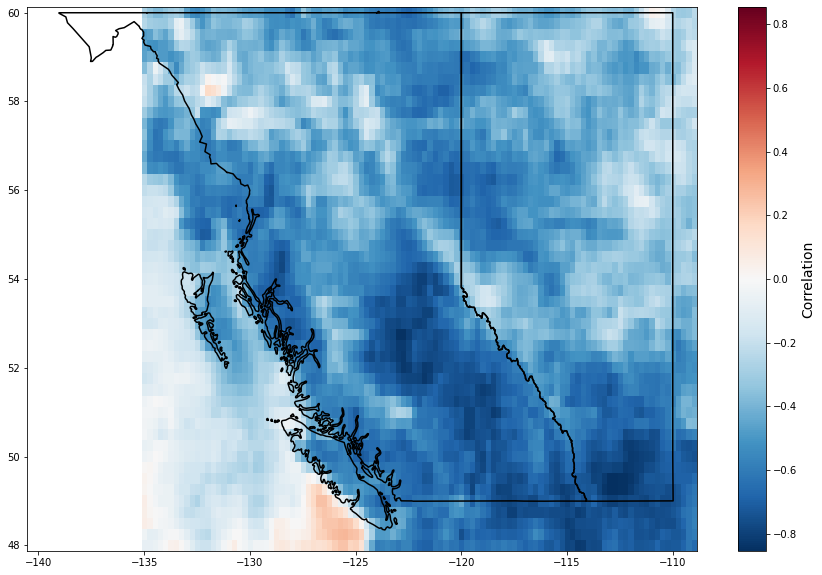

In [12]:
vmax = np.max(np.abs(corr))
vmin = -vmax

fig, ax = plt.subplots(figsize = (15,10))
im = ax.imshow(corr.reshape(105,49).T, aspect = 'auto', extent = extentERA, vmin = vmin, vmax = vmax, cmap = 'RdBu_r')
plot_prov_ax(prov = 'AB_BC', ax = ax)
cb = plt.colorbar(im)
cb.ax.set_ylabel('Correlation', fontsize = 14)

plt.show()

In [13]:
rgi_dir = dataPath + 'RGI/'
hypso_filename = '02_rgi60_WesternCanadaUS_hypso.csv'
poly_filename = '02_rgi60_WesternCanadaUS.shp'

In [14]:
hypso = pd.read_csv(rgi_dir + hypso_filename)
polys = gpd.read_file(rgi_dir + poly_filename)
cenLon = polys['CenLon']
cenLat = polys['CenLat']

In [23]:
# for glacier in range(len(polys)):
#   if (cenLon > minLon) and 

glacierInds = (cenLon > minLon) and (cenLon < maxLon)

ValueError: ignored

In [50]:
glacierInds = (cenLon > minLon) & (cenLon < maxLon) & (cenLat > minLat) & (cenLat < maxLat)
glacierInds = np.argwhere(glacierInds == 1)

ValueError: ignored

In [63]:
glacierInds = np.squeeze(np.argwhere(np.asarray(glacierInds) == 1))

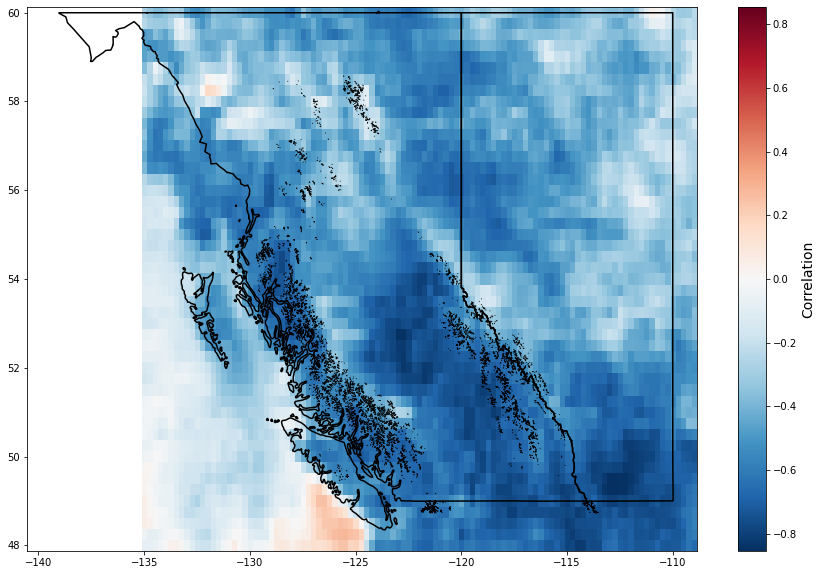

In [64]:
vmax = np.max(np.abs(corr))
vmin = -vmax

fig, ax = plt.subplots(figsize = (15,10))
im = ax.imshow(corr.reshape(105,49).T, aspect = 'auto', extent = extentERA, vmin = vmin, vmax = vmax, cmap = 'RdBu_r')
ax.scatter(cenLon[glacierInds], cenLat[glacierInds], linewidth = 0.5, edgecolor = [], facecolor = 'k', s = 1)
plot_prov_ax(prov = 'AB_BC', ax = ax)

# ax.set_xlim((extentERA[0], extentERA[1]))
# ax.set_ylim((extentERA[2], extentERA[3]))
cb = plt.colorbar(im)
cb.ax.set_ylabel('Correlation', fontsize = 14)

# plt.savefig('T_P_corr_no_glaciers.png', bbox_inches = 'tight', dpi = 150)

plt.show()

In [16]:
corrMat = corr.reshape(105,49).T

In [30]:
np.shape(corrMat)

(49, 105)

In [31]:
len(eraLon)

105

In [67]:
glacierCorr = np.zeros(len(glacierInds))

for kk, glacierInd in enumerate(glacierInds):

  dlon = cenLon[glacierInd] - eraLon
  dlat = cenLat[glacierInd] - eraLat
  
  minLonInd = np.argmin(np.abs(dlon))
  minLatInd = np.argmin(np.abs(dlat))

  glacierCorr[kk] = corrMat[minLatInd, minLonInd]

In [68]:
len(glacierCorr), len(glacierInds), len(cenLon), len(cenLon[glacierInds])

(13234, 13234, 18855, 13234)

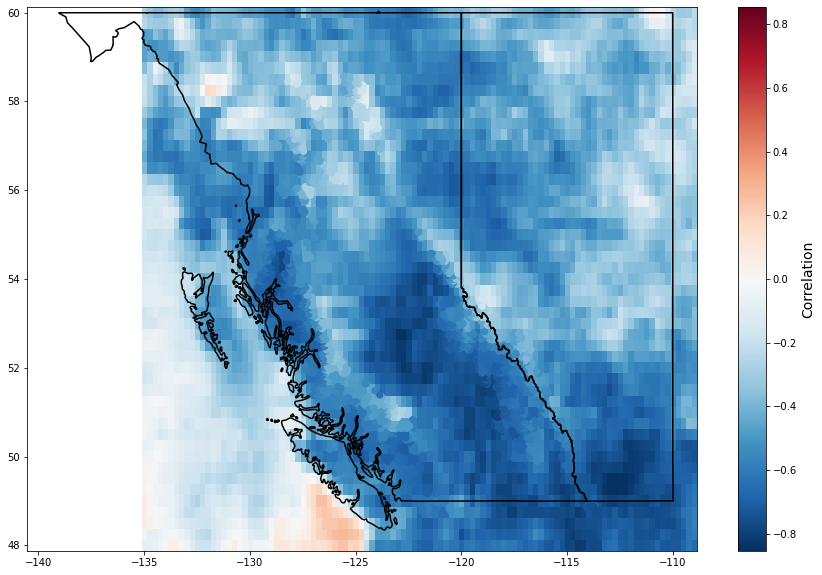

In [72]:
vmax = np.max(np.abs(corr))
vmin = -vmax

fig, ax = plt.subplots(figsize = (15,10))
im = ax.imshow(corr.reshape(105,49).T, aspect = 'auto', extent = extentERA, vmin = vmin, vmax = vmax, cmap = 'RdBu_r')
ax.scatter(cenLon[glacierInds], cenLat[glacierInds], c = glacierCorr, linewidth = 0.5, edgecolor = [], s = 50, cmap = 'RdBu_r', vmin = vmin, vmax = vmax)
plot_prov_ax(prov = 'AB_BC', ax = ax)

# ax.set_xlim((extentERA[0], extentERA[1]))
# ax.set_ylim((extentERA[2], extentERA[3]))
cb = plt.colorbar(im)
cb.ax.set_ylabel('Correlation', fontsize = 14)

# plt.savefig('T_P_corr_no_glaciers.png', bbox_inches = 'tight', dpi = 150)

plt.show()

(array([ 313., 2552., 4011., 2717., 1643.,  961.,  509.,  335.,  119.,
          74.]),
 array([-0.81138624, -0.73758561, -0.66378499, -0.58998436, -0.51618374,
        -0.44238312, -0.36858249, -0.29478187, -0.22098124, -0.14718062,
        -0.07338   ]),
 <a list of 10 Patch objects>)

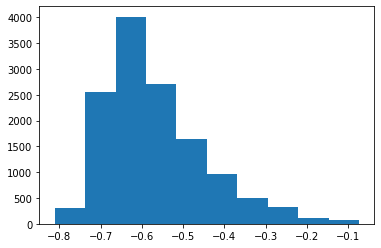

In [77]:
plt.hist(glacierCorr)

In [19]:
np.reshape(range(105*49), (105,49)).T[26,61]

3015

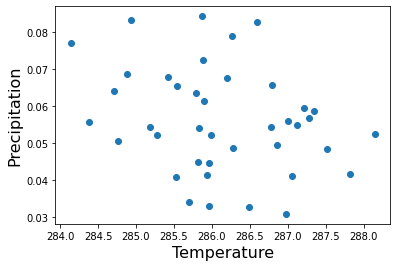

In [20]:
plt.scatter(Tmax_JJA_pixels[3014], P_JJA_pixels[3014])
plt.ylabel('Precipitation', fontsize = 16)
plt.xlabel('Temperature', fontsize = 16)

# plt.savefig('hot_dry_weak.png', bbox_inches = 'tight', dpi = 150)

plt.show()

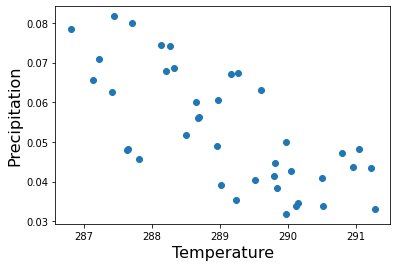

In [21]:
plt.scatter(Tmax_JJA_pixels[3020], P_JJA_pixels[3020])
plt.ylabel('Precipitation', fontsize = 16)
plt.xlabel('Temperature', fontsize = 16)

# plt.savefig('hot_dry.png', bbox_inches = 'tight', dpi = 150)

plt.show()

In [ ]:
a = P[:, indMaxLatERA:indMinLatERA+1, indMinLonERA:indMaxLonERA+1]
np.shape(P), np.shape(a), type(P), np.shape(Tmax)

((14609, 49, 105), (14609, 49, 77), numpy.ndarray, (14609, 49, 105))

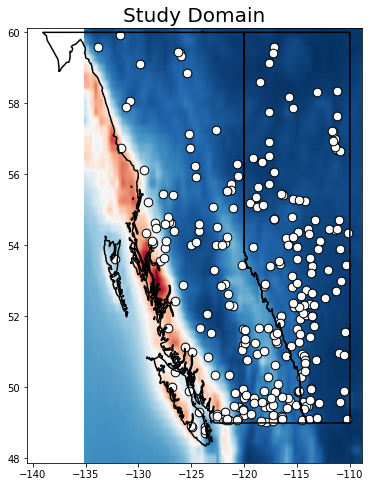

In [ ]:
#extentERA = [minLon,maxLon,minLat,maxLat]

fig, ax = plt.subplots(figsize = (6,8))
plot_prov_ax(prov = 'AB_BC', ax = ax)
ax.imshow(np.mean(P,axis = 0),aspect='auto',extent = extentERA, cmap = 'RdBu_r')
ax.scatter(stationLon[stationInds],stationLat[stationInds], facecolor = 'w', edgecolor = 'k', s = 75)
ax.set_title('Study Domain',fontsize = 20)

plt.show()

In [ ]:
#make data have same time range
startYear = max(int(np.min(eraYears)),int(np.min(flowYears)))

indStartERA = min(np.argwhere(eraYears==startYear))[0]
indStartFlow = min(np.argwhere(flowYears==startYear))[0]

Tmax = np.asarray(Tmax[indStartERA:])
Tmin = np.asarray(Tmin[indStartERA:])
P = np.asarray(P[indStartERA:])
# H = np.asarray(H[indStartERA:])
# S = np.asarray(S[indStartERA:])

flowDays = flowDays[indStartFlow:]
flowMonths = flowMonths[indStartFlow:]
flowYears = flowYears[indStartFlow:]

eraDays = eraDays[indStartERA:]
eraMonths = eraMonths[indStartERA:]
eraYears = eraYears[indStartERA:]


In [ ]:
print(np.shape(F),np.shape(Tmax),np.shape(P))#,np.shape(H),np.shape(S),np.shape(x_lat),np.shape(x_lon))

(13514, 14) (14609, 17, 28) (14609, 17, 28)


In [ ]:
#prep data: standardize

#indices of testing/training
trainStartYear = 1979
trainFinYear = 2000
valStartYear = 2001
valFinYear = 2010
testStartYear = 2011
testFinYear = 2015

trainInds = np.squeeze(np.argwhere((flowYears>=trainStartYear) & (flowYears<=trainFinYear)))
valInds = np.squeeze(np.argwhere((flowYears>=valStartYear) & (flowYears<=valFinYear)))
testInds = np.squeeze(np.argwhere((flowYears>=testStartYear) & (flowYears<=testFinYear)))
Ntrain = len(trainInds)
Nval = len(valInds)
Ntest = len(testInds)

#standardize variables individually (normalize wrt training period), then save as 32-bit rather than 64-bit for space
Tmaxmean_train = np.mean([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxstd_train = np.std([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxnorm = (Tmax - Tmaxmean_train)/Tmaxstd_train
Tmaxnorm = np.single(Tmaxnorm)

Tminmean_train = np.mean([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminstd_train = np.std([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminnorm = (Tmin - Tminmean_train)/Tminstd_train
Tminnorm = np.single(Tminnorm)

Pmean_train = np.mean([P[trainInds[ii]] for ii in range(len(trainInds))])
Pstd_train = np.std([P[trainInds[ii]] for ii in range(len(trainInds))])
Pnorm = (P - Pmean_train)/Pstd_train
Pnorm = np.single(Pnorm)

#normalize flow wrt to training period for each station
Fnorm = np.empty_like(F)
Fmean = np.zeros(len(stationInds))
Fstd = np.zeros(len(stationInds))
for station in range(np.shape(F)[1]):
  Fmean[station] = np.mean(F[trainInds,station])
  Fstd[station] = np.std(F[trainInds,station])
  Fnorm[:,station] = (F[:,station] - np.mean(F[trainInds,station]))/np.std(F[trainInds,station])


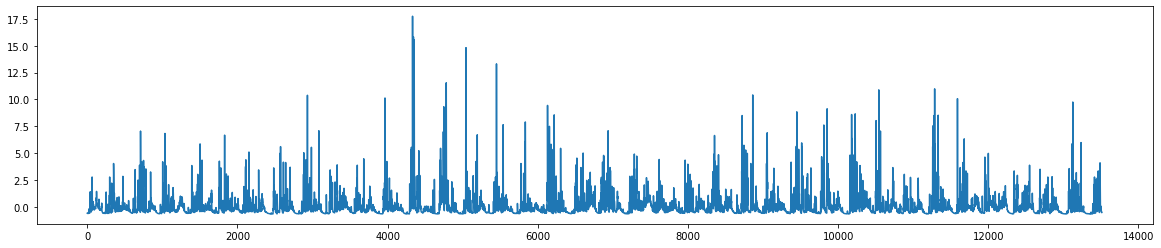

In [ ]:
plt.figure(figsize = (20,4))
plt.plot(Fnorm[:,9])
plt.show()

In [ ]:
#construct train and test predictor/target tensors

#target data
y_train = np.squeeze([Fnorm[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T #drop first 365 days since those are used to predict first flow day
y_val = np.squeeze([Fnorm[valInds,ii] for ii in range(np.shape(F)[1])]).T
y_test = np.squeeze([Fnorm[testInds,ii] for ii in range(np.shape(F)[1])]).T

y_train = y_train.astype(dtype = np.float16)
y_val = y_val.astype(dtype = np.float16)
y_test = y_test.astype(dtype = np.float16)

#predictor data
nchannels = 3 
x_train = np.empty((Ntrain-365, 365, ) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)
x_val = np.empty((Nval, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,), dtype = np.float16)
x_test = np.empty((Ntest, 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

#training
for ii in range(Ntrain-365):
  x_train[ii] = x_intermediate[ii:ii+365]

#validation
for ii in range(Nval):
  x_val[ii] = x_intermediate[ii + Ntrain - 365 : ii + Ntrain]

#testing
for ii in range(Ntest):
  x_test[ii] = x_intermediate[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval]

#convert predict/target arrays to tensors
x_test = tf.convert_to_tensor(x_test)
x_val = tf.convert_to_tensor(x_val)
x_train = tf.convert_to_tensor(x_train)
y_test = tf.convert_to_tensor(y_test)
y_val = tf.convert_to_tensor(y_val)
y_train = tf.convert_to_tensor(y_train)

In [ ]:
#set random seed

s = 00
seed(s)
np.random.seed(s)
tf.random.set_seed(s)

In [ ]:
#build model

learning_rate = 0.0001

#CNN model
print('Building model...')
model = Sequential()

model.add(TimeDistributed(
   Conv2D(filters = 32, kernel_size = (1,1), activation='relu',data_format='channels_last', padding='same'), 
   input_shape=(365,)+np.shape(Pnorm[0])+(nchannels,)))


model.add(TimeDistributed(
    Conv2D(filters = 16, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,)+np.shape(Pnorm[0])+(nchannels,)))

model.add(TimeDistributed(
    Conv2D(filters = 16, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,)+np.shape(Pnorm[0])+(nchannels,)))

model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

#model.add(Dropout(rate = 0.1))

model.add(TimeDistributed(
    Conv2D(filters = 32, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    ))

model.add(TimeDistributed(
    Conv2D(filters = 32, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    ))

#model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

model.add(TimeDistributed(
    GlobalMaxPooling2D(data_format='channels_last')))

model.add(TimeDistributed(Flatten()))

model.add(Dropout(rate = 0.1))


#model.add(LSTM(40, return_sequences=True))
#model.add(LSTM(40, return_sequences=False))
#model.add(LSTM(20, return_sequences=True))
#model.add(LSTM(20, return_sequences=False))
#model.add(LSTM(60, return_sequences=False))
model.add(LSTM(80, return_sequences=False))

model.add(Dense(np.shape(F)[1], activation = 'linear'))

#compile
print('Compiling model...')
model.compile(loss=tf.keras.losses.MSE,
                optimizer=tf.keras.optimizers.Adam(lr=learning_rate))

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience = 5,
                   restore_best_weights = True)

model.summary()

Building model...
Compiling model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_8 (TimeDist (None, 365, 17, 28, 32)   128       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 365, 17, 28, 16)   4624      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 365, 17, 28, 16)   2320      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 365, 8, 14, 16)    0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 365, 8, 14, 32)    4640      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 365, 8, 14, 32)    9248      
_________________________________________________________________
time_distributed_

In [ ]:
BUFFER_SIZE = len(trainInds)
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(Ntrain).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(Nval).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(Ntest).batch(BATCH_SIZE)

In [ ]:
#fit

train = 1

epochs = 200

if train:

  history = model.fit(
              train_dataset,
              validation_data = val_dataset,
              epochs=epochs,
              verbose=1, 
              callbacks = [es],
            )
    

In [ ]:
#save model

saveModel = 1
glacierStations = 0

if saveModel == 1:

  #save bulk model
  dir_all_models = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/ERA5_highres'
  model_name = 'model_bulk_' + str(s) + '.h5'
  model.save(dir_all_models + '/' + model_name)

In [ ]:
#load model

loadModel = 0

if loadModel == 1:

  dir_all_models = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/ERA5_highres'
  modelName = 'model_bulk_' + str(s) + '.h5'
  model = load_model(dir_all_models + '/' + modelName)

In [ ]:
model_bulk = tensorflow.keras.models.clone_model(model)

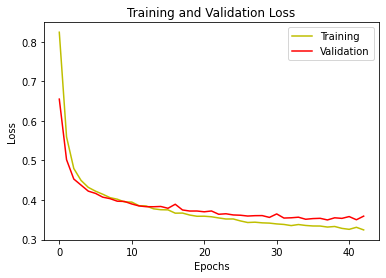

In [ ]:
#plot loss
trainModel = 1
saveIt = 0

if trainModel:

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.plot(loss, 'y', label='Training')
  plt.plot(val_loss, 'r', label='Validation')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  #plt.xlim((1,10))
  #plt.ylim((0,.1))
  #plt.show()

  if saveIt:
    plt.savefig('loss.png')

In [ ]:
batch_size = 64

print('Calculating predicted training values...')
y_train_predicted = model.predict(x_train, batch_size = batch_size, verbose = 1)

print('Calculating predicted testing values...')
y_test_predicted = model.predict(x_test, batch_size = batch_size, verbose = 1)

print('Calculating all predicted values...')
#y_predicted = model.predict(x, batch_size = 256, verbose = 1)
y_predicted = np.vstack((y_train_predicted,y_test_predicted))

Calculating predicted training values...
120/120 [==============================] - 6s 53ms/step
Calculating predicted testing values...
29/29 [==============================] - 2s 63ms/step
Calculating all predicted values...


# Investigate Performance in Space and Time

In [ ]:
#check r2 at each station

from sklearn.metrics import r2_score

r2 = np.empty(np.shape(F)[1])
for kk in range(np.shape(F)[1]):
  r2[kk] = r2_score(y_test[:,kk],y_test_predicted[:,kk])

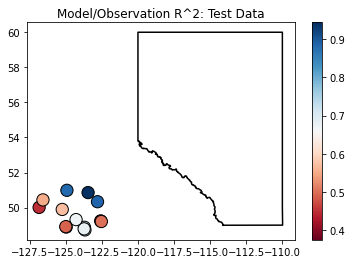

In [ ]:
#visualize

#plt.scatter(stationLon[stationInds],stationLat[stationInds],c=r2,cmap='RdBu',vmin = 0, s = 150, edgecolors = 'k')
plt.scatter(stationLon[stationInds],stationLat[stationInds],c=r2,cmap='RdBu', s = 150, edgecolors = 'k')
plot_AB()
plt.title('Model/Observation R^2: Test Data')
plt.colorbar()
plt.show()

In [ ]:
dataPath = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/'

#what are the streamflow predictions at each station?

num_stations = len(stationInds)

NSE_test = np.empty(len(stationInds))

for station in range(num_stations):

  NSE_station = nse(y_test[:,station].numpy(), y_test_predicted[:,station])
  NSE_test[station] = NSE_station

In [ ]:
print('Median Test NSE = ' + str(np.round(np.median(NSE_test), decimals = 2)))
print('')
print('Max Test NSE = ' + str(np.round(np.max(NSE_test), decimals = 2)))
print('')
print('Min Test NSE = ' + str(np.round(np.min(NSE_test), decimals = 2)))

Median Test NSE = 0.64

Max Test NSE = 0.94

Min Test NSE = 0.37


# What is the model learning?

In [ ]:
del x_train, history#, tempDict, precDict, flowDict, ssrdDict, spchDict

In [ ]:
#generate bulk heat maps

saveIt = 0
days_heat = range(365)
sigma = 1.5
style_dict = {'style' : 'gauss',
              'params' : sigma}
iters_total = 200
iters_one_pass = 50

print(' Making sensitivity heat maps')
output_dir_heat = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/ERA5_highres/heat_maps'
if not os.path.exists(output_dir_heat):
  os.mkdir(output_dir_heat)
output_dir_bulk_heat = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/ERA5_highres/heat_maps/bulk'
if not os.path.exists(output_dir_bulk_heat):
  os.mkdir(output_dir_bulk_heat)
heat_mean_bulk = make_heat(
    model = model, 
    x_test = x_test, 
    y_test = y_test, 
    style_dict = style_dict, 
    days = days_heat, 
    iters_total = iters_total, 
    iters_one_pass = iters_one_pass, 
    stationInds = range(len(stationInds)),
    verbose = 1
    )

if saveIt:
  fileName = 'heat_mean_bulk_' + str(s) + '.csv'
  np.savetxt(output_dir_bulk_heat + '/' + fileName, heat_mean_bulk, delimiter = ',')

 Making sensitivity heat maps
 Day 0/365
 Day 50/365
 Day 100/365
 Day 150/365
 Day 200/365
 Day 250/365
 Day 300/365
 Day 350/365


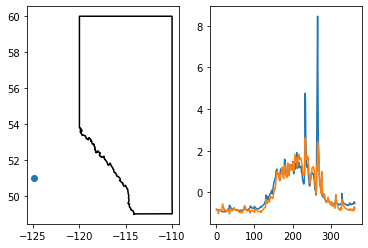

In [ ]:
station = 0
plt.subplot(121)
plot_prov(prov = prov)
plt.scatter(stationLon[stationInds[station]], stationLat[stationInds[station]])

plt.subplot(122)
plt.plot(y_test[:365,station])
plt.plot(y_test_predicted[:365,station])

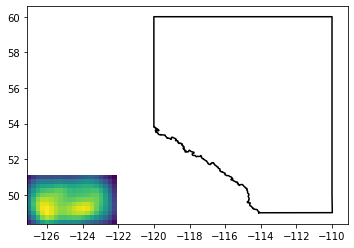

In [ ]:
hh = np.mean(heat_mean_bulk, axis=1)
plt.imshow(np.reshape(hh, np.shape(Tmax[0])), extent = extentERA)
plot_AB()

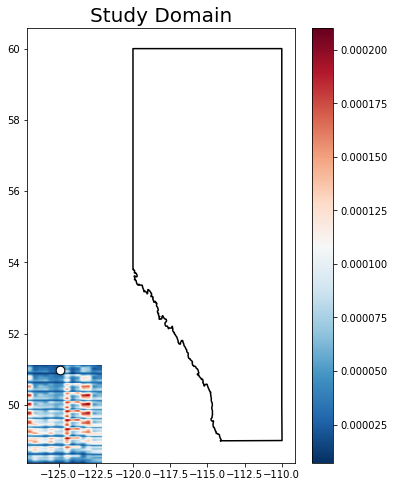

In [ ]:
#visualize: where is the model most sensitive on average?

plt.figure(figsize = (6,8))
plot_AB()
plt.imshow(heat_mean_bulk,aspect='auto', cmap = 'RdBu_r',extent = extentERA)
plt.colorbar()
plt.scatter(stationLon[stationInds[station]],stationLat[stationInds[station]], facecolor = 'w', edgecolor = 'k', s = 75)
plt.title('Study Domain',fontsize = 20)

plt.show()

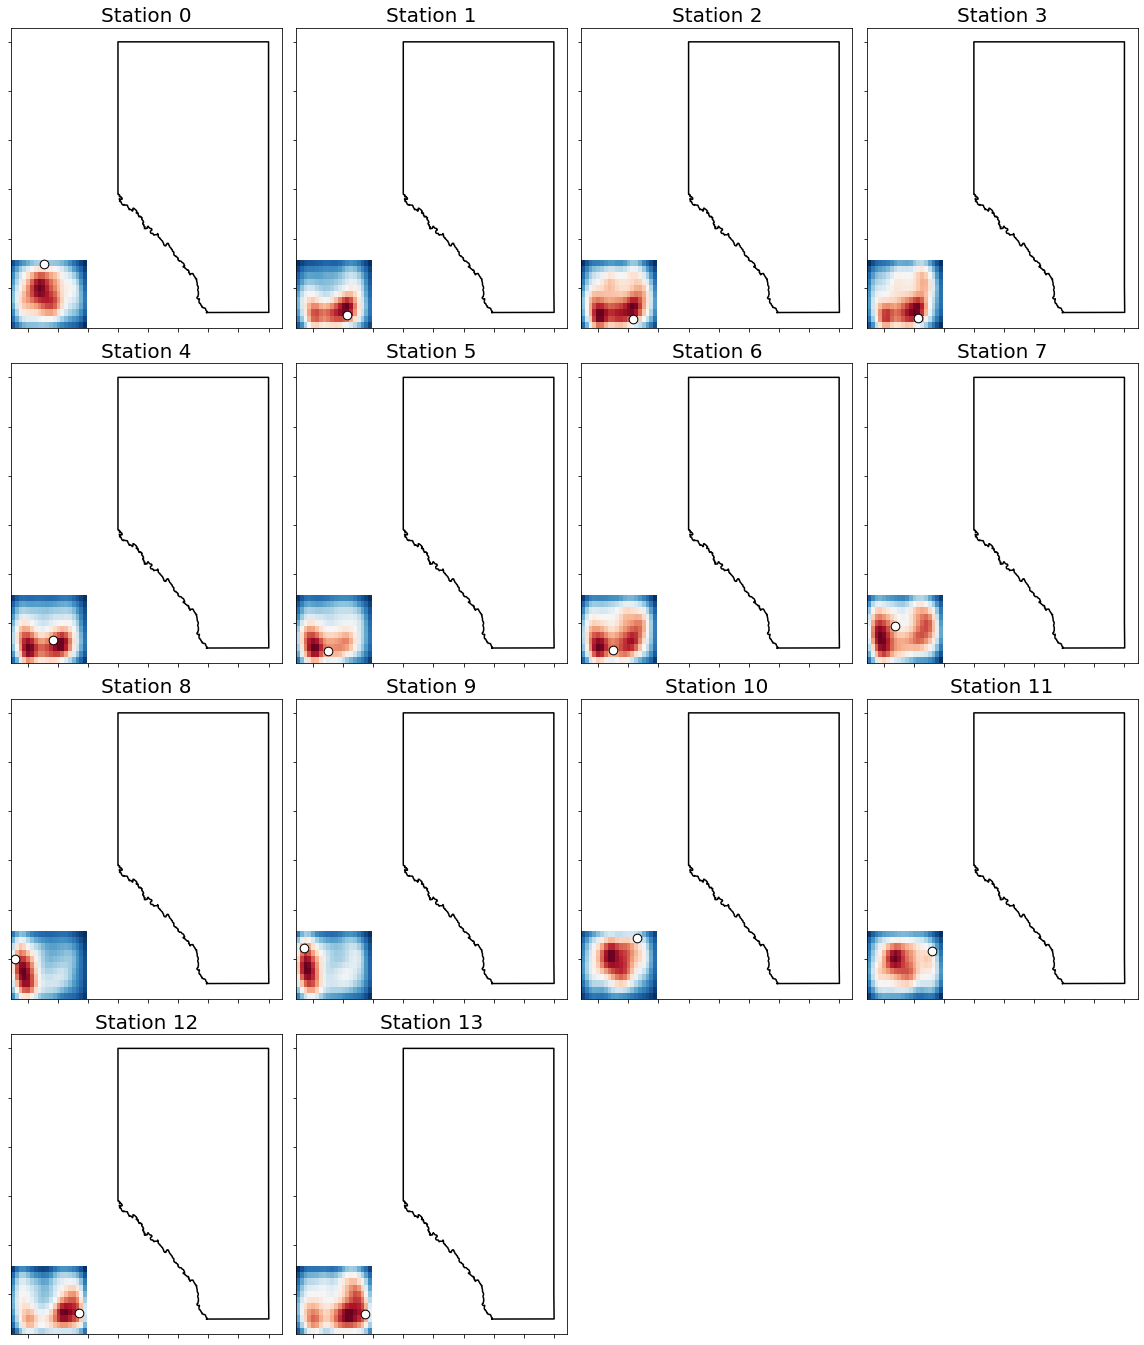

In [ ]:
#visualize: where is the model sensitive when predicting each station?

plt.figure(figsize = (4*4,len(stationInds)*5))

#vmin = np.min(heat_days)
#vmax = np.max(heat_days)

for kk in range(len(stationInds)):
  plt.subplot(len(stationInds)+1,4,kk+1)
  plt.imshow(np.reshape(heat_mean_bulk[:,kk], np.shape(Tmin[0])), aspect = 'auto', cmap = 'RdBu_r', extent = extentERA)#, vmin = vmin, vmax = vmax)
  plot_prov(prov = prov)
  plt.scatter(stationLon[stationInds[kk]],stationLat[stationInds[kk]], facecolor = 'w', edgecolor = 'k', s = 75)
  plt.title('Station ' + str(kk), fontsize = 20)
  plt.tick_params(labelbottom = False, labelleft = False)

plt.tight_layout()

# What is the model learning DURING training?

In [ ]:
def train_one_epoch(model, epochs, xtrain, ytrain, es):
  
  batch_size = 128
  history = model.fit(
            x_train, y_train,
            validation_split = 0.2,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1, 
            callbacks = [es],
          )
  
  return model, history

In [ ]:
def make_heat(station, x_test, y_test, model):
  
  iters_total = 100
  iters_one_pass = 100
  days = range(180,200) #number of days to perturb
  #day = 160 #day we're looking into
  station = station #station we're looking into
  p_1 = 0.9 #probability of 1 in mask
  perturb_single_channel = False #if true, only perturb one of the channels to see what it's looking at
  channel_perturb = 1 #if perturb_single_channel is True, this is the channel to be perturbing

  h = 3
  w = 3
  H = np.shape(x_test)[2]
  W = np.shape(x_test)[3]

  heat_all_slices = [[] for station in range(np.shape(y_test)[0])]
  heat_days = [[] for station in range(np.shape(y_test)[0])]
  jj = 0

  start = time.process_time()

  for day in days:

    print('Day ' + str(day) + '/' + str(days[-1]))

    for kk in range(int(iters_total/iters_one_pass)):

      print('   Iteration: ' + str(kk*iters_one_pass) + '/' + str(iters_total))

      now = time.process_time() - start
      #print('1: ' + str(now)[:6])

      iters = iters_one_pass

      x_int = np.arange(0,W+0.1,np.floor(W/w))
      y_int = np.arange(0,H+0.1,np.floor(H/h))
      xnew = np.arange(0,W,1)
      ynew = np.arange(0,H,1)

      now = time.process_time() - start
      #print('2: ' + str(now)[:6])

      mask_small = np.random.choice([0,1],size = (iters,1,h+1,w+1), p = [1-p_1,p_1])
      mask_large = np.half([interpolate.interp2d(x_int,y_int,mask_small[iter][0])(xnew,ynew) for iter in range(iters)])
      mask_large_2D = np.copy(mask_large)
      mask_large = np.repeat(np.expand_dims(np.asarray(mask_large),3),nchannels, axis = 3)
      mask_large = np.repeat(np.expand_dims(np.asarray(mask_large),1),365, axis = 1)

      now = time.process_time() - start
      #print('3: ' + str(now)[:6])

      if perturb_single_channel is True:
        for channel in range(nchannels):
          if channel != channel_perturb:
            mask_large[:,:,:,:,channel] = 1

      now = time.process_time() - start
      #print('4: ' + str(now)[:6])

      day_slice = [day]
      xday = x_test[day]

      now = time.process_time() - start
      #print('5a: ' + str(now)[:6])

      #xday_iters = [np.repeat(xday,iters,axis=0) for day in range(len(day_slice))] #dimension: [days, iterations*365, lat, lon, channels]
      ###xday_iters = [np.repeat(xday,iters,axis=0)]
      #print(np.shape(xday_iters))
      ###xday_iters = np.reshape(xday_iters, (iters, 365, ) + np.shape(T[0]) + (nchannels,)) #dimension: [days*iterations*365, lat, lon, channels]; for passing through model
      #print(np.shape(xday_iters))
      
      xday_iters = np.asarray([xday for val in range(iters)])

      now = time.process_time() - start
      #print('5b: ' + str(now)[:6])

      #xday_iters_mask = [xday_iters[jj:jj+iters] * mask_large for jj in np.arange(0,len(day_slice)*iters,iters)]
      if perturb_single_channel is True:
        xday_iters_mask = xday_iters
        xday_iters_mask[:,:,:,:,channel_perturb] = np.multiply(xday_iters[:,:,:,:,channel_perturb],mask_large[:,:,:,:,channel_perturb])
      else: 
        xday_iters_mask = np.multiply(xday_iters,mask_large)
      #print(np.shape(xday_iters_mask))

      now = time.process_time() - start
      #print('5c: ' + str(now)[:6])

      #xday_iters_mask = np.reshape(xday_iters_mask,(iters, 365) + np.shape(T[0]) + (nchannels,))
      #xday_iters_mask = np.squeeze(xday_iters_mask)
      #print(np.shape(xday_iters_mask))

      now = time.process_time() - start
      #print('5: ' + str(now)[:6])

      x_all = np.squeeze(np.concatenate((np.expand_dims(xday, axis = 0),xday_iters_mask)))
      #print(np.shape(x_all))
      y_all = model.predict(x_all, batch_size = 128)

      now = time.process_time() - start
      #print('6: ' + str(now)[:6])

      yday = y_all[:len(day_slice)]
      yday_mask = y_all[len(day_slice):]

      for station in range(np.shape(y_all)[1]):
        yday_station = yday[:,station]
        yday_station_mask = yday_mask[:,station]

        ydiffs = np.abs(np.reshape([yday_station[jj] - yday_station_mask[jj*iters:jj*iters + iters] for jj in range(len(day_slice))],(-1,1)))
        delta = np.ones((len(ydiffs),H,W)) * ydiffs[:,None]
        heat_iters = [np.asarray(delta[jj*iters:(jj+1)*iters]) * (1 - np.asarray(mask_large_2D)) for jj in range(len(day_slice))]
        heat_iters = np.reshape(heat_iters,(len(day_slice)*iters,H,W))
        heat = [np.mean(heat_iters[jj*iters : (jj+1)*iters], axis=0) for jj in range(len(day_slice))] #fast
        
        heat_all_slices[station].append(heat[0]) #fast
        #print(np.shape(heat_iters))

      del heat, heat_iters, delta, ydiffs, x_all, xday_iters

    for station in range(np.shape(y_all)[1]):
      heat_days[station].append(np.mean(heat_all_slices[station][jj : jj + int(iters_total/iters_one_pass)], axis = 0))
    jj += int(iters_total/iters_one_pass)

  heat_mean = np.empty( (np.shape(y_all)[1] ,) + np.shape(np.mean(heat_all_slices[0],axis=0)) )
  heat_max = np.empty( (np.shape(y_all)[1] ,) + np.shape([np.max(heat_days[0][kk]) for kk in range(len(days))]))
  for station in range(np.shape(y_all)[1]):
    heat_mean[station] = np.mean(heat_all_slices[station],axis=0)
    heat_max[station] = [np.max(heat_days[station][kk]) for kk in range(len(days))]

  now = time.process_time() - start
  print(    str(now)[:6])

  return heat_mean

In [ ]:
#define model
%tensorflow_version 2.x
import tensorflow
import tensorflow.keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = 0.0001

#CNN model
print('Building model...')
model = Sequential()

model.add(TimeDistributed(
    Conv2D(filters = 8, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))

model.add(TimeDistributed(
    Conv2D(filters = 8, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))

model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

model.add(TimeDistributed(
    Conv2D(filters = 16, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
    ))

model.add(TimeDistributed(
    Conv2D(filters = 16, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
    ))

model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

model.add(TimeDistributed(Flatten()))

model.add(Dropout(rate = 0.2))

model.add(LSTM(40, return_sequences=True))

model.add(Flatten())
model.add(Dense(np.shape(F)[1], activation = 'linear'))

#compile
print('Compiling model...')
model.compile(loss=tensorflow.keras.losses.MSE,
              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate))

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience = 3,
                   restore_best_weights = True)

model.summary()

Building model...
Compiling model...
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_49 (TimeDis (None, 365, 18, 24, 8)    368       
_________________________________________________________________
time_distributed_50 (TimeDis (None, 365, 18, 24, 8)    584       
_________________________________________________________________
time_distributed_51 (TimeDis (None, 365, 9, 12, 8)     0         
_________________________________________________________________
time_distributed_52 (TimeDis (None, 365, 9, 12, 16)    528       
_________________________________________________________________
time_distributed_53 (TimeDis (None, 365, 9, 12, 16)    1040      
_________________________________________________________________
time_distributed_54 (TimeDis (None, 365, 4, 6, 16)     0         
_________________________________________________________________
time_distributed_

In [ ]:
epoch_sets = 5
epochs_per_set = 3
station = 1
heat_mean_epochs = []

for epoch_set in range(epoch_sets):
  
  if epoch_set == 0: #if first set, run one epoch to get inital model sensitivity
    #model, history = train_one_epoch(model, 1, x_train, y_train, es)
    heat_mean = make_heat(station, x_test, y_test, model)
  else: #if after first set, run epochs_per_set and then recalculate sensitivity
    model, history = train_one_epoch(model, epochs_per_set, x_train, y_train, es)
    heat_mean = make_heat(station, x_test, y_test, model)
    
  heat_mean_epochs.append(heat_mean)

Day 180/199
   Iteration: 0/100
Day 181/199
   Iteration: 0/100
Day 182/199
   Iteration: 0/100
Day 183/199
   Iteration: 0/100
Day 184/199
   Iteration: 0/100
Day 185/199
   Iteration: 0/100
Day 186/199
   Iteration: 0/100
Day 187/199
   Iteration: 0/100
Day 188/199
   Iteration: 0/100
Day 189/199
   Iteration: 0/100
Day 190/199
   Iteration: 0/100
Day 191/199
   Iteration: 0/100
Day 192/199
   Iteration: 0/100
Day 193/199
   Iteration: 0/100
Day 194/199
   Iteration: 0/100
Day 195/199
   Iteration: 0/100
Day 196/199
   Iteration: 0/100
Day 197/199
   Iteration: 0/100
Day 198/199
   Iteration: 0/100
Day 199/199
   Iteration: 0/100
29.486
Train on 5260 samples, validate on 1315 samples
Epoch 1/3
5260/5260 [==============================] - 16s 3ms/sample - loss: 0.0789 - val_loss: 0.0464
Epoch 2/3
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0405 - val_loss: 0.0430
Epoch 3/3
5260/5260 [==============================] - 14s 3ms/sample - loss: 0.0371 - val_loss: 

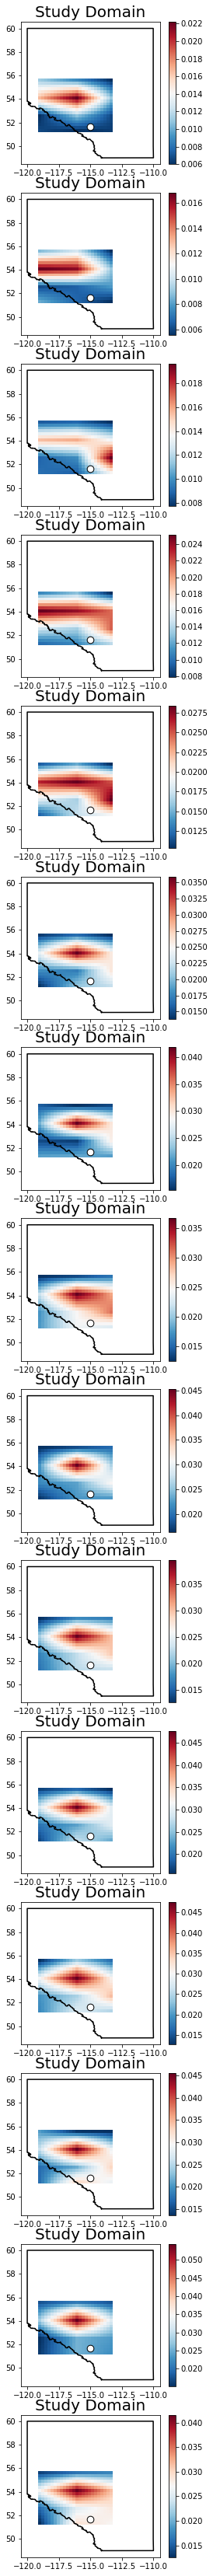

In [ ]:


vmax = np.max(heat_mean_epochs)
vmin = np.min(heat_mean_epochs)

plt.figure(figsize = (4, 4*epoch_sets))

for epoch_set in range(epoch_sets):

  plt.subplot(epoch_sets, 1, epoch_set+1)
  plot_prov(prov = prov)
  #plt.imshow(heat_mean_epochs[epoch_set],aspect='auto', cmap = 'RdBu_r',extent = extentERA, vmin = vmin, vmax = vmax)
  plt.imshow(heat_mean_epochs[epoch_set],aspect='auto', cmap = 'RdBu_r',extent = extentERA)
  plt.colorbar()
  plt.scatter(stationLon[stationInds[station]],stationLat[stationInds[station]], facecolor = 'w', edgecolor = 'k', s = 75, zOrder = 5)
  plt.title('Study Domain',fontsize = 20)